In [ ]:
# ! pip install tensorflow==2.0.0

In [38]:
# Import the relevant libraries
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns
import requests
import matplotlib.pyplot as plt

In [39]:
# Import the relevant libraries
import os
import json
import zipfile
import shutil
import random
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from shutil import copyfile

print(tf.__version__)

2.3.0


In [66]:
# Import the inception V3 model  
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Clear any exiting model
tf.keras.backend.clear_session()

pre_trained_model = InceptionV3(input_shape = (150,150,3), # reshape images to 150 by 150 by 3 channels
                                include_top = False, # get straight to the CNN layer
                                weights = 'imagenet') # use the builed-in weight pre-trained on imagent

# Make all the layers in the pre-trained model non-trainable/frozen
for layer in pre_trained_model.layers:
    layer.trainable = False

In [67]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

__________________________________________________________________________________________________
conv2d_68 (Conv2D)              (None, 7, 7, 192)    258048      activation_67[0][0]              
__________________________________________________________________________________________________
conv2d_69 (Conv2D)              (None, 7, 7, 192)    147456      average_pooling2d_6[0][0]        
__________________________________________________________________________________________________
batch_normalization_60 (BatchNo (None, 7, 7, 192)    576         conv2d_60[0][0]                  
__________________________________________________________________________________________________
batch_normalization_63 (BatchNo (None, 7, 7, 192)    576         conv2d_63[0][0]                  
__________________________________________________________________________________________________
batch_normalization_68 (BatchNo (None, 7, 7, 192)    576         conv2d_68[0][0]                  
__________

In [68]:
# Pick one layer from the middle of the model
# We well build new dense layers after this layer

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [69]:
# Define a Callback class that stops training once accuracy reaches a threshold

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('acc')>0.875):
            print("\nReached 87.5% accuracy so cancelling training!")
            self.model.stop_training = True

In [70]:
from tensorflow.keras.optimizers import RMSprop

# Add layers after the picked last_layer
# Note that the layers below are trainable. 
# On the other hand, the layers up to the last_output is fronzen and non-trainable.

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)

# Add a final sigmoid layer for binary classification
# x = layers.Dense(1, activation='sigmoid')(x)           
                  
# Add a final softmax layer for classification
x = layers.Dense(3, activation='softmax')(x)         

# instantiate a new model 
model = Model(pre_trained_model.input ,x) 

# Compile a model
model.compile(optimizer = RMSprop(lr=0.0001),  # We use RMSprop in this case
              loss = 'categorical_crossentropy',  # up, flat, or down
              metrics = ['acc']) # 'acc' stands for accuracy

# See the summary of the model 
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

activation_69 (Activation)      (None, 7, 7, 192)    0           batch_normalization_69[0][0]     
__________________________________________________________________________________________________
mixed7 (Concatenate)            (None, 7, 7, 768)    0           activation_60[0][0]              
                                                                 activation_63[0][0]              
                                                                 activation_68[0][0]              
                                                                 activation_69[0][0]              
__________________________________________________________________________________________________
flatten (Flatten)               (None, 37632)        0           mixed7[0][0]                     
__________________________________________________________________________________________________
dense (Dense)                   (None, 1024)         38536192    flatten[0][0]                    
__________

Store the files 

Five days ahead

In [56]:
#train_set and test_set
base_train_dir = './capstone_data/train_data_5'
base_val_dir = './capstone_data/test_data_5'

#up
train_up_fnames = os.listdir('./capstone_data/train_data_5/up_data')
print(train_up_fnames)

#flat
train_flat_fnames = os.listdir('./capstone_data/train_data_5/flat_data')
print(train_flat_fnames)

#down
train_down_fnames = os.listdir('./capstone_data/train_data_5/down_data')
print(train_down_fnames)

['up_mpf_candle_1993-03-15.png', 'up_mpf_candle_1993-04-13.png', 'up_mpf_candle_1993-05-11.png', 'up_mpf_candle_1993-06-09.png', 'up_mpf_candle_1993-07-08.png', 'up_mpf_candle_1993-10-15.png', 'up_mpf_candle_1993-12-13.png', 'up_mpf_candle_1993-12-28.png', 'up_mpf_candle_1994-01-25.png', 'up_mpf_candle_1994-04-07.png', 'up_mpf_candle_1994-08-30.png', 'up_mpf_candle_1994-09-14.png', 'up_mpf_candle_1994-10-26.png', 'up_mpf_candle_1994-11-23.png', 'up_mpf_candle_1995-01-09.png', 'up_mpf_candle_1995-01-23.png', 'up_mpf_candle_1995-02-06.png', 'up_mpf_candle_1995-03-07.png', 'up_mpf_candle_1995-03-21.png', 'up_mpf_candle_1995-04-04.png', 'up_mpf_candle_1995-05-03.png', 'up_mpf_candle_1995-05-17.png', 'up_mpf_candle_1995-06-29.png', 'up_mpf_candle_1995-07-14.png', 'up_mpf_candle_1995-07-28.png', 'up_mpf_candle_1995-08-25.png', 'up_mpf_candle_1995-09-25.png', 'up_mpf_candle_1995-10-09.png', 'up_mpf_candle_1995-12-05.png', 'up_mpf_candle_1995-12-19.png', 'up_mpf_candle_1996-01-04.png', 'up_mpf

Three days ahead

In [47]:
#train_set and test_set
base_train_dir = './capstone_data/train_data_3/'
base_val_dir = './capstone_data/test_data_3/'

#up
train_up_fnames = os.listdir('./capstone_data/train_data_3/up_data')
print(train_up_fnames)

#flat
train_flat_fnames = os.listdir('./capstone_data/train_data_3/flat_data')
print(train_flat_fnames)

#down
train_down_fnames = os.listdir('./capstone_data/train_data_3/down_data')
print(train_down_fnames)

['up_mpf_candle_1993-05-11.png', 'up_mpf_candle_1993-06-09.png', 'up_mpf_candle_1993-06-23.png', 'up_mpf_candle_1993-07-08.png', 'up_mpf_candle_1993-12-13.png', 'up_mpf_candle_1994-03-09.png', 'up_mpf_candle_1994-04-07.png', 'up_mpf_candle_1994-08-30.png', 'up_mpf_candle_1994-09-14.png', 'up_mpf_candle_1994-10-12.png', 'up_mpf_candle_1994-10-26.png', 'up_mpf_candle_1994-12-08.png', 'up_mpf_candle_1995-01-09.png', 'up_mpf_candle_1995-01-23.png', 'up_mpf_candle_1995-02-06.png', 'up_mpf_candle_1995-03-07.png', 'up_mpf_candle_1995-03-21.png', 'up_mpf_candle_1995-04-19.png', 'up_mpf_candle_1995-05-03.png', 'up_mpf_candle_1995-05-17.png', 'up_mpf_candle_1995-06-29.png', 'up_mpf_candle_1995-07-28.png', 'up_mpf_candle_1995-08-11.png', 'up_mpf_candle_1995-08-25.png', 'up_mpf_candle_1995-09-25.png', 'up_mpf_candle_1995-10-09.png', 'up_mpf_candle_1995-12-05.png', 'up_mpf_candle_1995-12-19.png', 'up_mpf_candle_1996-01-18.png', 'up_mpf_candle_1996-02-01.png', 'up_mpf_candle_1996-02-15.png', 'up_mpf

One day ahead

In [71]:
#train_set and test_set
base_train_dir = './capstone_data/train_data_1/'
base_val_dir = './capstone_data/test_data_1/'

#up
train_up_fnames = os.listdir('./capstone_data/train_data_1/up_data')
print(train_up_fnames)

#flat
train_flat_fnames = os.listdir('./capstone_data/train_data_1/flat_data')
print(train_flat_fnames)

#down
train_down_fnames = os.listdir('./capstone_data/train_data_1/down_data')
print(train_down_fnames)

['up_mpf_candle_1993-04-13.png', 'up_mpf_candle_1993-05-11.png', 'up_mpf_candle_1994-08-02.png', 'up_mpf_candle_1994-09-14.png', 'up_mpf_candle_1995-01-09.png', 'up_mpf_candle_1995-06-01.png', 'up_mpf_candle_1995-06-29.png', 'up_mpf_candle_1995-10-09.png', 'up_mpf_candle_1995-12-05.png', 'up_mpf_candle_1996-01-18.png', 'up_mpf_candle_1996-02-01.png', 'up_mpf_candle_1996-02-15.png', 'up_mpf_candle_1996-03-29.png', 'up_mpf_candle_1996-06-11.png', 'up_mpf_candle_1996-07-10.png', 'up_mpf_candle_1996-07-24.png', 'up_mpf_candle_1996-08-21.png', 'up_mpf_candle_1996-09-05.png', 'up_mpf_candle_1996-12-13.png', 'up_mpf_candle_1996-12-30.png', 'up_mpf_candle_1997-03-26.png', 'up_mpf_candle_1997-04-10.png', 'up_mpf_candle_1997-04-24.png', 'up_mpf_candle_1997-05-22.png', 'up_mpf_candle_1997-06-06.png', 'up_mpf_candle_1997-07-07.png', 'up_mpf_candle_1997-08-18.png', 'up_mpf_candle_1997-11-25.png', 'up_mpf_candle_1997-12-10.png', 'up_mpf_candle_1997-12-24.png', 'up_mpf_candle_1998-01-09.png', 'up_mpf

Rescale the files and feed them into generator

In [72]:
# Rescale the training_data
train_datagen = ImageDataGenerator(rescale = 1.0/255.0) # rescale the images within 0-1. This yield better results when handling images. 

# Rescale the test data
test_datagen = ImageDataGenerator(rescale = 1.0 / 255.0)

# Flow training images in batches of 10 using train_datagen generator
train_generator = train_datagen.flow_from_directory(base_train_dir,
                                                    batch_size = 10,
                                                    class_mode = 'categorical',
                                                    target_size = (150, 150))     

# Flow validation images in batches of 10 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory(base_val_dir,
                                                         batch_size = 10,
                                                         class_mode = 'categorical',
                                                         target_size = (150,150))

Found 587 images belonging to 3 classes.
Found 98 images belonging to 3 classes.


In [73]:
# See the indices of the classes
# In keras ImageDataGenerator class, classes are indexed in alphabetical order
train_generator.class_indices

{'down_data': 0, 'flat_data': 1, 'up_data': 2}

Training 

For five days ahead

In [74]:
# Fit the model the training data
# Take the log of the training in history
callbacks = myCallback()
history = model.fit_generator(generator = train_generator, # feed the training data via the generator
                              steps_per_epoch = 8, # this is the batch size. parameters are updated per this batch size
                              epochs = 100, # number of cycles. In one epoch, the whole dataset is used once.
                              verbose = 2, # print out the logs
                              callbacks = [callbacks], # use callbacks we set before
                              validation_data = validation_generator, # feed the validation data via the generator
                              validation_steps = 10 
                              )

Epoch 1/100
8/8 - 6s - loss: 2.2616 - acc: 0.3000 - val_loss: 1.0522 - val_acc: 0.4490
Epoch 2/100
8/8 - 4s - loss: 1.3087 - acc: 0.4125 - val_loss: 1.1705 - val_acc: 0.6429
Epoch 3/100
8/8 - 4s - loss: 1.5054 - acc: 0.3875 - val_loss: 1.6634 - val_acc: 0.1633
Epoch 4/100
8/8 - 3s - loss: 1.0651 - acc: 0.4500 - val_loss: 1.8148 - val_acc: 0.1837
Epoch 5/100
8/8 - 3s - loss: 1.0398 - acc: 0.5325 - val_loss: 0.9994 - val_acc: 0.6020
Epoch 6/100
8/8 - 3s - loss: 1.1796 - acc: 0.4250 - val_loss: 1.4868 - val_acc: 0.1939
Epoch 7/100
8/8 - 3s - loss: 0.9171 - acc: 0.6250 - val_loss: 1.1128 - val_acc: 0.6429
Epoch 8/100
8/8 - 3s - loss: 1.0058 - acc: 0.5500 - val_loss: 1.0997 - val_acc: 0.6224
Epoch 9/100
8/8 - 3s - loss: 0.9419 - acc: 0.6000 - val_loss: 1.2058 - val_acc: 0.3776
Epoch 10/100
8/8 - 3s - loss: 1.1565 - acc: 0.4500 - val_loss: 1.1041 - val_acc: 0.5306
Epoch 11/100
8/8 - 3s - loss: 1.0190 - acc: 0.5714 - val_loss: 1.3229 - val_acc: 0.2857
Epoch 12/100
8/8 - 3s - loss: 1.0515 - ac

In [65]:
# You can also evaluate or predict on a dataset.
print("Evaluate")
result = model.evaluate(test_data_5)
dict(zip(model.metrics_names, result))

Evaluate


NameError: name 'test_data_5' is not defined

Training

For three days ahead

In [50]:
# Fit the model the training data
# Take the log of the training in history
callbacks = myCallback()
history = model.fit_generator(
    generator = train_generator, # feed the training data via the generator
    steps_per_epoch = 8, # this is the batch size. parameters are updated per this batch size
    epochs = 100, # number of cycles. In one epoch, the whole dataset is used once.
    verbose = 2, # print out the logs
    callbacks = [callbacks], # use callbacks we set before
    validation_data = validation_generator, # feed the validation data via the generator
    validation_steps = 10 
)

Epoch 1/100
8/8 - 7s - loss: 2.8024 - acc: 0.3500 - val_loss: 1.2903 - val_acc: 0.2551
Epoch 2/100
8/8 - 4s - loss: 1.2447 - acc: 0.3625 - val_loss: 1.3433 - val_acc: 0.3776
Epoch 3/100
8/8 - 4s - loss: 1.1680 - acc: 0.4750 - val_loss: 1.1170 - val_acc: 0.4490
Epoch 4/100
8/8 - 4s - loss: 1.1720 - acc: 0.4500 - val_loss: 1.1918 - val_acc: 0.4184
Epoch 5/100
8/8 - 4s - loss: 1.2148 - acc: 0.4250 - val_loss: 1.1426 - val_acc: 0.4490
Epoch 6/100
8/8 - 4s - loss: 1.1501 - acc: 0.3500 - val_loss: 1.5743 - val_acc: 0.3367
Epoch 7/100
8/8 - 4s - loss: 1.0996 - acc: 0.4625 - val_loss: 1.1238 - val_acc: 0.4082
Epoch 8/100
8/8 - 4s - loss: 1.0497 - acc: 0.4500 - val_loss: 1.4349 - val_acc: 0.3776
Epoch 9/100
8/8 - 3s - loss: 1.0679 - acc: 0.5125 - val_loss: 1.1473 - val_acc: 0.2959
Epoch 10/100
8/8 - 3s - loss: 1.0216 - acc: 0.4375 - val_loss: 1.9073 - val_acc: 0.3776
Epoch 11/100
8/8 - 3s - loss: 1.0569 - acc: 0.4875 - val_loss: 1.2697 - val_acc: 0.3571
Epoch 12/100
8/8 - 4s - loss: 0.9794 - ac

Training

For one day ahead

In [ ]:
# Fit the model the training data
# Take the log of the training in history
callbacks = myCallback()
history = model.fit_generator(
    generator = train_generator, # feed the training data via the generator
    steps_per_epoch = 8, # this is the batch size. parameters are updated per this batch size
    epochs = 100, # number of cycles. In one epoch, the whole dataset is used once.
    verbose = 2, # print out the logs
    callbacks = [callbacks], # use callbacks we set before
    validation_data = validation_generator, # feed the validation data via the generator
    validation_steps = 10 
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
8/8 - 78s - loss: 2.1859 - acc: 0.4125 - val_loss: 2.5488 - val_acc: 0.2143
Epoch 2/100
8/8 - 32s - loss: 1.7109 - acc: 0.2625 - val_loss: 1.3493 - val_acc: 0.2551
Epoch 3/100
8/8 - 28s - loss: 1.1922 - acc: 0.3875 - val_loss: 1.3835 - val_acc: 0.3265
Epoch 4/100
8/8 - 25s - loss: 1.1777 - acc: 0.4000 - val_loss: 1.3632 - val_acc: 0.3367
Epoch 5/100
8/8 - 27s - loss: 1.1686 - acc: 0.5000 - val_loss: 1.1670 - val_acc: 0.4082
Epoch 6/100
8/8 - 19s - loss: 1.1541 - acc: 0.3875 - val_loss: 1.3214 - val_acc: 0.3673
Epoch 7/100
8/8 - 18s - loss: 1.1484 - acc: 0.4875 - val_loss: 1.8213 - val_acc: 0.4490
Epoch 8/100
8/8 - 13s - loss: 1.2264 - acc: 0.4625 - val_loss: 1.6282 - val_acc: 0.2653
Epoch 9/100
8/8 - 15s - loss: 1.1022 - acc: 0.4250 - val_loss: 1.5359 - val_acc: 0.4286
Epoch 10/100
8/8 - 10s - loss: 1.0752 - acc: 0.4875 - val_loss: 1.2281 - val_acc: 0.3571
Epoch 11/100
8/8 - 7s - loss: 1.0582 - acc:

Results for the five days ahead forecast

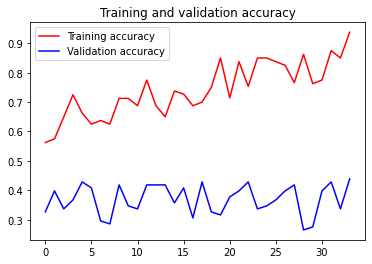

<Figure size 432x288 with 0 Axes>

In [64]:
# Five days ahead
# Plot the accuracy history 
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

At Epoch 55/100, training acc spiked to 0.7 and the validatation(test) accuracy is 0.40802

8/8 - 2s - loss: 0.6222 - acc: 0.8000 - val_loss: 1.4024 - val_acc: 0.4082

Test accuracy of 0.4286 is the highest during the training
<hr>

Results for the three days ahead forecast

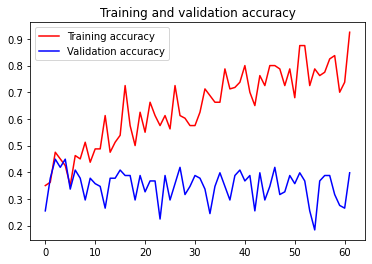

<Figure size 432x288 with 0 Axes>

In [51]:
# Three days ahead
# Plot the accuracy history 
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

At the Epoch 47, training acc spiked to 0.8 and the validation(test) accuracy reaached 0.469. 


Epoch 47/100
8/8 - 2s - loss: 0.5926 - acc: 0.8000 - val_loss: 1.3668 - val_acc: 0.4694

Test accuracy of 0.5 is the highest during the training

<hr>

Results for the one day ahead forcast

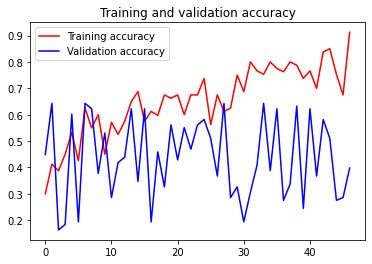

<Figure size 432x288 with 0 Axes>

In [75]:
# One day ahead
# Plot the accuracy history 
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

At Epoch, 55/100 The accuracy spiked to 0.8:

8/8 - 2s - loss: 0.6222 - acc: 0.8000 - val_loss: 1.4024 - val_acc: 0.4082

Test data accuracy of 0.4490 is the highest during the training
<hr>

Results for the three days ahead forecast